In [1]:
import tensorflow as tf 
import numpy as np
from Seq2Seq import helpers

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [3]:
PAD = 0
EOS = 1
vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 512
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None),dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_tarets')

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

In [7]:
((encoder_fw_outputs, 
  encoder_bw_outputs),
 (encoder_fw_final_state, 
  encoder_bw_final_state)) = (tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                                              cell_bw=encoder_cell,
                                                              inputs=encoder_inputs_embedded,
                                                              sequence_length=encoder_inputs_length,
                                                              dtype=tf.float32, time_major=True))

In [8]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [9]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [11]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
encoder_final_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = tf.contrib.rnn.LSTMStateTuple(c=encoder_final_state_c,
                                                    h=encoder_final_state_h)

In [13]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

In [14]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [15]:
decoder_lengths = encoder_inputs_length + 3 

In [16]:
w = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [17]:
assert EOS == 1 and PAD == 0
eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [18]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None
    return (initial_elements_finished, initial_input, initial_cell_state, 
            initial_cell_output, initial_loop_state)

In [19]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, w), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    element_finished = (time >= decoder_lengths)
    
    finished = tf.reduce_all(element_finished)
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None
    return element_finished, input, state, output, loop_state

In [20]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [21]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [22]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, w), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, 
                                                  decoder_batch_size, 
                                                  vocab_size))

In [23]:
decoder_prediction = tf.argmax(decoder_logits, 2) 

In [24]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_targets, 
                                                                                   depth=vocab_size,
                                                                                   dtype=tf.float32),
                                                                 logits=decoder_logits)

In [25]:
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [26]:
sess.run(tf.global_variables_initializer())

In [27]:

batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[2, 2, 3]
[6, 2, 9, 4]
[9, 6, 4, 6, 6, 5, 8]
[8, 3, 9]
[7, 4, 9]
[2, 5, 4, 8]
[6, 3, 4, 7, 2]
[8, 3, 2, 8, 4, 3]
[7, 8, 5, 5, 3]
[6, 2, 8, 8, 7, 8, 6, 6]


In [28]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [29]:
loss_track = []


In [31]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0


  minibatch loss: 2.1978447437286377


  sample 1:
    input     > [7 6 7 9 3 5 0 0]
    predicted > [5 5 0 0 0 0 0 0 0 0 0]
  sample 2:
    input     > [6 2 7 5 8 9 9 0]
    predicted > [0 0 0 0 0 0 0 0 0 0 0]
  sample 3:
    input     > [4 9 2 6 4 6 8 5]
    predicted > [9 9 3 9 3 9 3 9 9 3 9]



batch 1000
  minibatch loss: 0.5083218812942505
  sample 1:
    input     > [6 6 3 0 0 0 0 0]
    predicted > [6 6 3 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [8 2 3 9 0 0 0 0]
    predicted > [8 2 3 9 1 0 0 0 0 0 0]
  sample 3:
    input     > [8 6 9 7 2 3 8 0]
    predicted > [8 6 7 3 2 9 8 1 0 0 0]



batch 2000
  minibatch loss: 0.2135542780160904
  sample 1:
    input     > [2 4 5 0 0 0 0 0]
    predicted > [2 4 5 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [2 9 2 6 5 6 5 0]
    predicted > [2 9 6 2 6 6 5 1 0 0 0]
  sample 3:
    input     > [6 4 8 9 0 0 0 0]
    predicted > [6 4 8 9 1 0 0 0 0 0 0]



batch 3000
  minibatch loss: 0.13412830233573914
  sample 1:
    input     > [6 6 6 7 7 8 7 0]
    predicted > [6 6 6 7 7 8 7 1 0 0 0]
  sample 2:
    input     > [7 8 6 0 0 0 0 0]
    predicted > [7 8 6 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [8 5 7 6 7 2 2 5]
    predicted > [8 5 7 6 6 2 2 5 1 0 0]



loss 0.1476 after 300100 examples (batch_size=100)


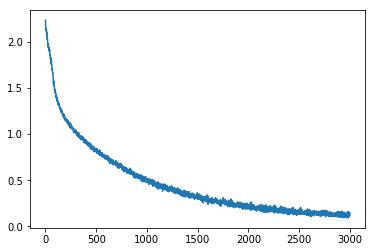

In [31]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))